<a href="https://colab.research.google.com/github/RishabhJha395/ytsentiment_analysis/blob/main/youtubeCommentSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from googleapiclient.discovery import build
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import nltk, re, os

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import userdata

API_KEY = userdata.get("YOUTUBE_API_KEY")

In [3]:
def extract_video_id(url):
    match = re.search(r"v=([a-zA-Z0-9_-]{11})", url)
    if match:
        return match.group(1)
    else:
        raise ValueError("Invalid YouTube video URL")


In [4]:
def fetch_video_details(video_id):
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    request = youtube.videos().list(
        part="snippet,statistics",
        id=video_id
    )
    response = request.execute()

    if not response["items"]:
        return None

    data = response["items"][0]
    snippet = data["snippet"]
    stats = data["statistics"]

    # Fetch category name (requires extra API call)
    category_id = snippet["categoryId"]
    cat_request = youtube.videoCategories().list(
        part="snippet", id=category_id
    )
    cat_response = cat_request.execute()
    category_name = cat_response["items"][0]["snippet"]["title"]

    video_data = {
        "title": snippet["title"],
        "channel": snippet["channelTitle"],
        "published_date": snippet["publishedAt"],
        "category": category_name,
        "views": int(stats.get("viewCount", 0)),
        "likes": int(stats.get("likeCount", 0)) if "likeCount" in stats else 0,
        "comments": int(stats.get("commentCount", 0)) if "commentCount" in stats else 0,
    }
    return video_data


In [5]:
def process_youtube_video(video_url):
    # --- Extract video info ---
    video_id = extract_video_id(video_url)
    video_info = fetch_video_details(video_id)

    print("🎥 Video Details:")
    for k, v in video_info.items():
        print(f"{k.title()}: {v}")
    print()

    # --- Fetch comments ---
    comments = fetch_comments(video_id)
    df = pd.DataFrame(comments, columns=["Comment"])

    # --- Clean and Analyze ---
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    import re
    from textblob import TextBlob
    import matplotlib.pyplot as plt

    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Clean comment text
    def clean_text(text):
        text = re.sub(r"http\S+", "", text)         # remove URLs
        text = re.sub(r"[^a-zA-Z]", " ", text)      # keep only letters
        text = text.lower()
        words = text.split()
        words = [ps.stem(w) for w in words if w not in stop_words]
        return " ".join(words)

    # Analyze sentiment using TextBlob
    def analyze_sentiment(text):
        if not text.strip():
            return "Neutral"
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0.1:
            return "Positive"
        elif polarity < -0.1:
            return "Negative"
        else:
            return "Neutral"

    df["Cleaned"] = df["Comment"].apply(clean_text)
    df["Sentiment"] = df["Cleaned"].apply(analyze_sentiment)

    # --- Summary ---
    summary = df["Sentiment"].value_counts().to_dict()
    total = len(df)
    for k in summary:
        summary[k] = round(summary[k] / total * 100, 2)

    print("\n📊 Sentiment Distribution (in %):")
    for k, v in summary.items():
        print(f"{k}: {v}%")

    # --- Save results ---
    df.to_csv("youtube_comments_with_sentiment.csv", index=False)
    print("\n💾 Saved comments with sentiments to CSV")

    # --- Visualization ---
    plt.figure(figsize=(5, 5))
    plt.pie(summary.values(), labels=summary.keys(), autopct='%1.1f%%', startangle=90)
    plt.title("YouTube Comment Sentiment Pie Chart")
    plt.show()

    # --- Like Ratio ---
    like_ratio = 0
    if video_info["views"] > 0:
        like_ratio = round(video_info["likes"] / video_info["views"] * 100, 2)

    print(f"\n👍 Like Ratio: {like_ratio}% of viewers liked this video")

    # Return data for further use
    return df, summary, video_info


In [6]:
from googleapiclient.discovery import build
import pandas as pd




def fetch_comments(video_id, max_results=100):
    youtube = build("youtube", "v3", developerKey=API_KEY)
    comments = []

    # YouTube comments API
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,  # max 100 per page
        textFormat="plainText"
    )

    while request and len(comments) < max_results:
        response = request.execute()

        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comments.append(comment)

        # Handle pagination
        request = youtube.commentThreads().list_next(request, response)

        if len(comments) >= max_results:
            break

    return comments

##Sentimental Analysis along with summary

Enter YouTube video URL: https://www.youtube.com/watch?v=k09uvR5eUao&list=RDT94PHkuydcw&index=2
🎥 Video Details:
Title: Tum Tak - Full Video Song | Raanjhanaa | Dhanush | Sonam Kapoor | A. R. Rahman
Channel: Sony Music India
Published_Date: 2013-08-12T10:17:34Z
Category: Music
Views: 96382722
Likes: 598963
Comments: 11285


📊 Sentiment Distribution (in %):
Neutral: 87.0%
Positive: 13.0%

💾 Saved comments with sentiments to CSV


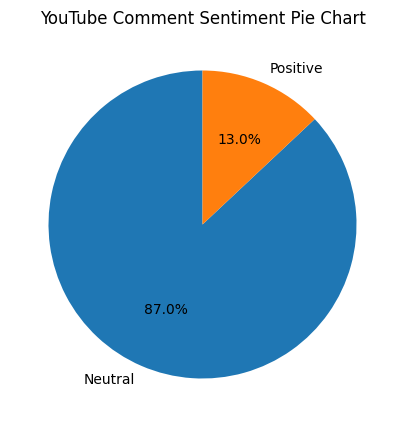


👍 Like Ratio: 0.62% of viewers liked this video


In [7]:
video_url = input("Enter YouTube video URL: ")
df, summary, video_info = process_youtube_video(video_url)


##Most frequent words

In [8]:

from wordcloud import WordCloud

positive_comments = " ".join(df[df['Sentiment']=='Positive']['Cleaned'])
negative_comments = " ".join(df[df['Sentiment']=='Negative']['Cleaned'])

wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Green').generate(positive_comments)
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_comments)

plt.figure(figsize=(10,5))
plt.imshow(wc_pos)
plt.axis("off")
plt.title("Word Cloud - Positive Comments")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Word Cloud - Negative Comments")
plt.show()


ValueError: 'Green' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

##Sentiment Polarity Histogram

In [ ]:
df["Polarity"] = df["Cleaned"].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(6,4))
plt.hist(df["Polarity"], bins=20, color='skyblue', edgecolor='black')
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity (-1 = Negative, +1 = Positive)")
plt.ylabel("Comment Count")
plt.show()


##Emotion Classification

In [ ]:
from transformers import pipeline

# Load the emotion classification model
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base"
)

sample = input("Enter the Comment for which you want the emotion     :")
result = emotion_classifier(sample)[0]   # get first (and only) prediction
print(result['label'].upper())



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


###Keyword Analysis

In [ ]:
from collections import Counter

all_words = " ".join(df["Cleaned"]).split()
common_words = Counter(all_words).most_common(10)
print(common_words)


words, counts = zip(*common_words)
plt.bar(words, counts)
plt.title("Top 10 Common Words in Comments")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization")
summary_text = summarizer(" ".join(df["Comment"][:50]), max_length=80, min_length=25, do_sample=False)
print(summary_text[0]['summary_text'])
